In [12]:
#!/usr/bin/env python
# coding: utf-8
##get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

In [13]:
# ### Params :

np.random.seed(42)

## Number of assets
n_assets = 5

## Number of observations
n_obs = 1000

#Randomly generates returns on each asset, for each observations (like a timeseries)
return_vec = np.random.randn(n_assets, n_obs) 

In [14]:
# ### Functions : 

#Produces n random weights that sum to 1
def rand_weights(n):
    
    k = np.random.rand(n)
    return k / sum(k)


#Returns a random portfolio defined by the mean and standard deviation of returns  
def random_portfolio(returns):    

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T #mean returns of portfolio
    sigma = np.sqrt(w * C * w.T) #std returns of portfolio
    
    return mu, sigma

#Generate random portfolios, defined by their mean and std of returns, using the previous function
def generate_portfolios(n_portfolios=500):
    
    means, stds = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])
    
    return means, stds

In [15]:
#Plot the randomly generated portfolios
def plot_portfolio(n_portfolios=500):
    means, stds = generate_portfolios(n_portfolios)
    fig = plt.figure()
    plt.plot(stds, means, 'o', markersize=5)
    plt.title("Représentation graphiques des portefeuilles du marché")
    plt.ylabel('Rendements')
    plt.xlabel('Risques')
    plt.savefig("Ptfs-Marchés.png",dpi=144)

In [16]:

#Compute the optimal portfolio, based on Markowitz theory - Source : https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/
def optimal_portfolio(returns):
    
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] #Used to avoid linear mean
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

     pcost       dcost       gap    pres   dres
 0: -3.2651e-03 -1.0570e+00  1e+00  2e-16  3e+00
 1: -5.7123e-03 -6.4691e-02  6e-02  1e-16  2e-01
 2: -2.4295e-02 -3.9014e-02  1e-02  1e-16  2e-17
 3: -2.7257e-02 -2.8756e-02  1e-03  2e-16  2e-17
 4: -2.7931e-02 -2.7999e-02  7e-05  1e-16  3e-17
 5: -2.7968e-02 -2.7969e-02  8e-07  2e-16  1e-17
 6: -2.7969e-02 -2.7969e-02  8e-09  1e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0107e-03 -1.0554e+00  1e+00  2e-16  3e+00
 1: -4.4058e-03 -6.2803e-02  6e-02  2e-16  2e-01
 2: -2.1326e-02 -3.4904e-02  1e-02  1e-16  3e-17
 3: -2.4122e-02 -2.5429e-02  1e-03  2e-16  2e-17
 4: -2.4724e-02 -2.4777e-02  5e-05  2e-16  8e-18
 5: -2.4768e-02 -2.4769e-02  7e-07  1e-16  2e-17
 6: -2.4769e-02 -2.4769e-02  7e-09  2e-16  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0608e-04 -1.0536e+00  1e+00  0e+00  3e+00
 1: -2.9447e-03 -6.0703e-02  6e-02  1e-16  2e-01
 2: -1.8284e-02 -3.0687e

<Figure size 640x480 with 0 Axes>

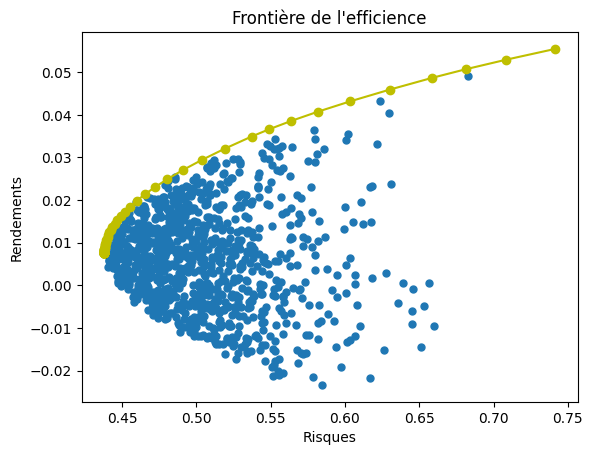

In [17]:
fig = plt.figure()
plot_portfolio(1000)
weights, returns, risks = optimal_portfolio(return_vec)
plt.plot(risks, returns, 'y-o')

plt.title("Frontière de l'efficience")
plt.ylabel('Rendements')
plt.xlabel('Risques')
plt.savefig("Frotnière-efficience.png",dpi=144)

print (weights)
print(np.sum(weights)) #100% is invested in n_assets (5 assets in this example)